In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from functools import partial
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('data/processed/heart_risk.csv')
irrelevant = ['id']
df = df.drop(irrelevant, axis=1)

We'll start by handling some of the missing values in the dataset. The following cell shows the missing value proportion for each column.

In [3]:
df.isna().mean().sort_values()

age                      0.000000
sex                      0.000000
source                   0.000000
cad                      0.000000
cp_type                  0.000000
rest_ecg                 0.002225
angiogram_date           0.014461
ekg_date                 0.060067
ex_angina                0.061179
heart_rate_peak          0.061179
heart_rate_rest          0.062291
ex_duration              0.062291
ex_hypotension           0.064516
blood_press_s_rest       0.065628
blood_press_d_rest       0.065628
st_dep                   0.068966
blood_press_s_peak       0.070078
ccblocker_used           0.070078
blood_press_d_peak       0.070078
nitrate_used             0.072303
betablocker_used         0.074527
digitalis_used           0.075640
diuretic_used            0.091212
fasting_blood_sugar      0.100111
met                      0.116796
ex_protocol              0.124583
rldv5e                   0.157953
chol                     0.224694
cp_substernal            0.313682
cp_exertion   

First, let's focus on the columns where at least 50% of the values are missing. That's not a number backed by any theory, we just need somewhere to start. Let's look at each column in this set from the one with the most to the one with the least missing values.
- `pncaden` is supposedly a summary of chest pain variables, but since all of its values are missing, there's not much we can do other than dropping it
- `ejection_frac_ex`, `wm_abnormal_ex`, `wm_abnormal_rest` and `ejection_frac_rest` all relate to ejection fraction measurements and heart wall abnormalities. These seem like they could be strongly correlated to CAD, but they're all ranging from 96% to 99% missing, so we're gonna drop these also.
- Even though `diabetes` is a known predictor of heart disease, the amount of missing values in this dataset makes it really hard for us to draw any conclusions about it. We'll keep an eye on other possible indicators of diabetes, like fasting blood sugar, but for now, at 87% missing, this is not suitable for our analysis. Let's drop that one as well.
- smoking is commonly associated with a high risk of heart disease, and even though the `smoker` column's values are missing in 74% of the rows, there are other proxies available (like smoker_cigs_per_day and smoker_years) that can help us determine some of the missing values.
- `vessels_colored` is a numeric direct measurement from a medical test, which is certainly valuable for our analysis. We'll keep this column for now and look at ways to deal with the missing values.
- `thalium_stress_result` is one of the main test results gathered, so we'll keep it for now and try to impute values where possible.
- `st_dep_measured_at` may not provide valuable data, but we'll check it for correlation and see if we can use it in any way.

From these observations, we can start by dropping all columns with 75% missing values or more.

In [4]:
df = df.drop(df.isna().mean()[df.isna().mean() >= .75].index, axis=1)

In [4]:
def infer_smoking(row):
    """
    Description:
        Uses information in the `smoker_cigs_per_day` and `smoker_years` columns to infer whether a patient smokes
    
    Arguments:
        row : The dataset row (or patient) to be analysed

    Returns:
        out : a new value for the `smoker` column based on our inference heuristic
    """

    if row.smoker == 'yes' or row.smoker_cigs_per_day > 0 or row.smoker_years > 0:
        out = 'yes'
    else:
        out = row.smoker
    return out


before_nan_mean = df.smoker.isna().mean()
before_nan_count = df.smoker.isna().sum()

df.smoker = df.apply(infer_smoking, axis=1)

after_nan_mean = df.smoker.isna().mean()
after_nan_count = df.smoker.isna().sum()

print("Smoker had {} ({:.2f}%) new values inferred from other columns".format(before_nan_count - after_nan_count, (before_nan_mean - after_nan_mean)*100))

Smoker had 167 (18.58%) new values inferred from other columns


We got almost 20% extra values for the smoker column by inferring missing values!

There's a "catch" in the data found earlier during EDA. Let's investigate the rldv5 and rldv5e columns

cleveland_minus_corrupted has 0 valid entries for rldv5. mean value is nan 

hungarian has 293 valid entries for rldv5. mean value is 13.68259385665529 

long-beach-va has 135 valid entries for rldv5. mean value is 16.007407407407406 

switzerland has 46 valid entries for rldv5. mean value is 14.23913043478261 

cleveland_minus_corrupted has 282 valid entries for rldv5e. mean value is 123.58510638297872 

hungarian has 294 valid entries for rldv5e. mean value is 13.295918367346939 

C:\Users\guizi\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\guizi\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2595: RuntimeWarning: Mean of e

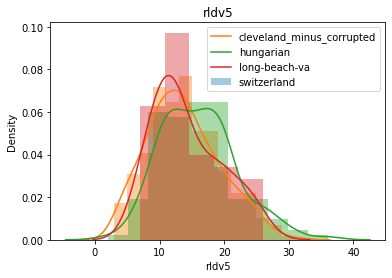

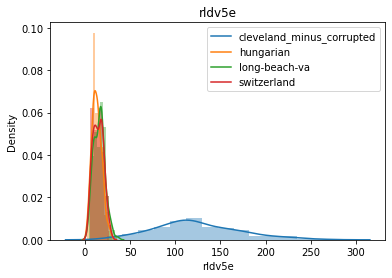

In [8]:
def plot_hist(df_, col):
    """Wrapping function for easier hist plotting with additional metrics showed"""
    print(df_.source.unique()[0], 'has', len(df_[col].dropna()), f'valid entries for {col}. mean value is', df_[col].mean(), '\n')
    sns.distplot(df_[col])


df.groupby('source').apply(partial(plot_hist, col='rldv5'))
plt.title('rldv5')
plt.legend(df.groupby('source').groups.keys())

plt.figure()
df.groupby('source').apply(partial(plot_hist, col='rldv5e'))
plt.title('rldv5e')
plt.legend(df.groupby('source').groups.keys())

it seems like there are no rldv5 values in the cleveland dataset. It also looks like the values were taken at two different scales (or units) between the data sources. We can either drop these columns, remap the cleveland values to a sensible range and keep one of the columns (rldv5e), or drop all cleveland observations to keep both columns.

C:\Users\guizi\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\guizi\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\guizi\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

<AxesSubplot:xlabel='rldv5e', ylabel='Density'>

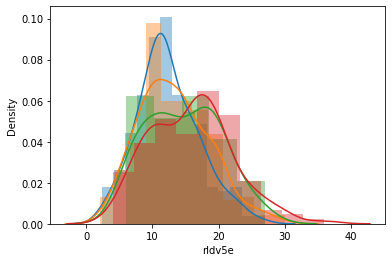

In [7]:
sns.distplot(df[df.source == 'cleveland_minus_corrupted'].rldv5e / 10)
sns.distplot(df[df.source == 'hungarian'].rldv5e)
sns.distplot(df[df.source == 'switzerland'].rldv5e)
sns.distplot(df[df.source == 'long-beach-va'].rldv5e)

There appears to be a 10x scale between the observed values for rldv5e in cleveland as opposed to other sources. We'll remap these and keep the column.

In [8]:
df.rldv5e = df.apply(lambda row: row.rldv5e / 10 if row.source=='cleveland_minus_corrupted' else row.rldv5e, axis=1)

# Classification problem setup (Variables and Target)
Let's define a binary classification column as our target and drop the original CAD column from the predictors. We'll also create a new feature based on the date columns and drop those.

In [9]:
def setup_classification_problem(df_):
    df = df_.copy()
    df['target'] = df.cad.map(lambda x: 1 if x > 0 else 0)
    df['days_between_tests'] = (pd.to_datetime(df.angiogram_date) - pd.to_datetime(df.ekg_date)).map(lambda x: x.days)
    return df


def fill_missing(df_):
    fill_mean = lambda col: col.fillna(col.mean())
    fill_mode = lambda col: col.fillna(col.mode()[0])

    df = df_.copy()
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in df.columns:
        if col in cat_cols:
            print(f'Filling categorical col {col} with mode {df[col].mode()[0]} ({df[col].isna().sum()} missing)')
            df[col] = fill_mode(df[col])
        else:
            print(f'Filling numerical col {col} with mean {df[col].mean()} ({df[col].isna().sum()} missing)')
            df[col] = fill_mean(df[col])
    return df


def create_dummies(X_):
    cat_cols = list(X_.select_dtypes(include=['object']).columns)
    for col in cat_cols.copy():
        if len(X_[col].dropna().unique()) == 2:
            # Keep binary cat cols as numeric 0 and 1
            if all([v in ['yes', 'no'] for v in X_[col].dropna().unique()]):
                cat_cols.remove(col)
                X_[col] = X_[col].replace({'yes': 1, 'no': 0})
                X_[col] = pd.to_numeric(X_[col])
                
    numeric = X_[[c for c in X_.columns if c not in cat_cols]].copy()
    X = pd.concat([pd.get_dummies(X_[cat_cols]), numeric], axis=1)
    return X

In [10]:
clean_and_fill = lambda x: fill_missing(setup_classification_problem(x))

clean = clean_and_fill(df)
date_cols = ['ekg_date', 'angiogram_date']

X = clean.drop(date_cols + ['cad', 'source'], axis=1)
X = create_dummies(X)
y = clean.target.copy()

Filling numerical col age with mean 53.480533926585096 (0 missing)
Filling categorical col sex with mode M (0 missing)
Filling categorical col cp_substernal with mode yes (282 missing)
Filling categorical col cp_exertion with mode yes (282 missing)
Filling categorical col cp_rest_relieve with mode yes (286 missing)
Filling categorical col cp_type with mode no_pain (0 missing)
Filling numerical col blood_press_s_rest with mean 132.10119047619048 (59 missing)
Filling numerical col chol with mean 247.8077474892396 (202 missing)
Filling categorical col smoker with mode yes (502 missing)
Filling numerical col smoker_cigs_per_day with mean 19.11899791231733 (420 missing)
Filling numerical col smoker_years with mean 18.796573875803 (432 missing)
Filling numerical col fasting_blood_sugar with mean 0.1668726823238566 (90 missing)
Filling categorical col heart_disease_family with mode yes (422 missing)
Filling categorical col rest_ecg with mode normal (2 missing)
Filling categorical col digitali

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899 entries, 0 to 898
Data columns (total 61 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   sex_F                               899 non-null    uint8  
 1   sex_M                               899 non-null    uint8  
 2   cp_type_atypical_angina             899 non-null    uint8  
 3   cp_type_no_pain                     899 non-null    uint8  
 4   cp_type_non_anginal                 899 non-null    uint8  
 5   cp_type_typical_angina              899 non-null    uint8  
 6   rest_ecg_hypertrophy                899 non-null    uint8  
 7   rest_ecg_normal                     899 non-null    uint8  
 8   rest_ecg_st-t_abnormal              899 non-null    uint8  
 9   ex_protocol_100.0                   899 non-null    uint8  
 10  ex_protocol_125.0                   899 non-null    uint8  
 11  ex_protocol_130.0                   899 non-n

# Question 1
What are some of the key indicators of coronary artery disease?

In [21]:
for name, value in X.corr().target.sort_values().items():
    print('{:<35} {:>8.4f}'.format(name, value))

cp_type_atypical_angina              -0.3965
heart_rate_peak                      -0.3813
sex_F                                -0.3218
ex_duration                          -0.2834
thalium_stress_result_normal         -0.2774
heart_rate_rest                      -0.2102
cp_type_non_anginal                  -0.2101
st_slope_peak_up                     -0.1729
ex_protocol_100.0                    -0.1631
ex_protocol_175.0                    -0.1287
ex_protocol_75.0                     -0.1244
blood_press_s_peak                   -0.1038
ex_protocol_125.0                    -0.0923
rest_ecg_normal                      -0.0883
ex_protocol_150.0                    -0.0648
cp_type_typical_angina               -0.0592
ex_protocol_130.0                    -0.0369
days_between_tests                   -0.0284
smoker                               -0.0279
digitalis_used                       -0.0249
heart_disease_family                 -0.0184
blood_press_d_peak                   -0.0141
ex_protoco

In [14]:
# Output the correlations as a markdown table for medium
with open('data/results/correlations.md', 'w') as out:
    correlations = X.corr().target.sort_values().drop('target').round(decimals=4)
    correlations.name = 'Correlation to target'
    out.write(correlations.to_markdown(tablefmt='github'))


In [15]:
X.to_csv('data/processed/clean_and_filled.csv', index=None)

Some of these correlation values are expected, based on the literature: 
- `ex_angina` at 0.43 indicates that the presence of exercise-induced chest pain is correlated with coronary artery disease.
- `st_dep` at 0.37 tells us that there is a direct correlation between the ST wave segment depression measured during the EKG and coronary artery disease.
- Both `age` and `sex_M` are positively correlated with coronary artery disease

But others raise some interesting questions:
- Is there a reason why `cp_type_no_pain` (no chest pain reported) should be the most strongly positively correlated feature in this dataset?
    - One possibility is that this sample is biased in some way, if for example we assume that having no pain is the default. That still does not explain the imbalance between sick and healthy individuals with no chest pain.
- What does it mean to have found that serum cholesterol feature `chol` is negatively correlated to our target?
    - Even though cholesterol might be an indicator of coronary obstruction, serum cholesterol is not a good direct proxy for identifying that problem.


Are men more prone to report no chest pain, while also being more susceptible to CAD? this would skew our data towards no chest pain being a predictor for CAD.

In [16]:
men_with_cad = X.groupby(['target']).sex_M.value_counts()
men_with_cad

target  sex_M
0       1        261
        0        143
1       1        450
        0         45
Name: sex_M, dtype: int64

In [17]:
men_no_cp = X.groupby(['sex_M']).cp_type_no_pain.value_counts()
men_no_cp

sex_M  cp_type_no_pain
0      0                  122
       1                   66
1      1                  419
       0                  292
Name: cp_type_no_pain, dtype: int64

In [18]:
print('Men who report no chest pain')
print(men_no_cp[(1, 1)] / (X.sex_M == 1).sum() * 100, '%')

print('Women who report no chest pain')
print(men_no_cp[(0, 1)] / (X.sex_M == 0).sum() * 100, '%')


Men who report no chest pain
58.93108298171589 %
Women who report no chest pain
35.1063829787234 %


In [19]:
men_cad = X.groupby(['sex_M']).target.value_counts()
men_cad

sex_M  target
0      0         143
       1          45
1      1         450
       0         261
Name: target, dtype: int64

In [20]:
print('Men afflicted by CAD')
print(men_cad[(1, 1)] / (X.sex_M == 1).sum() * 100, '%')

print('Women afflicted by CAD')
print(men_cad[(0, 1)] / (X.sex_M == 0).sum() * 100, '%')

Men afflicted by CAD
63.29113924050633 %
Women afflicted by CAD
23.93617021276596 %
